In [35]:
import pandas as pd
import numpy as np
from collections import Counter

In [36]:
#import data 
df=pd.read_csv('~/Downloads/data_train_all.csv')
data_columns=pd.read_csv('~/Downloads/data_train_all_columns.csv')

Many n-gram features are highly correlated with correlation coefficient greater than .7 in magnitude. 

In [37]:
#find high correlation n-gram variables
predictor_ngrams_columns = data_columns[data_columns['column_type'] == 'predictor_n_grams']['column_name'].tolist()
corr_matrix = df[predictor_ngrams_columns].corr()
# Get pairs with high correlation (excluding diagonal)
high_corr = corr_matrix.where(
    (corr_matrix.abs() > 0.7) & (corr_matrix != 1.0)
).stack().sort_values(ascending=False)
print(f"Pairs with |correlation| > 0.7:\n{high_corr}")

print(f"\nHighly correlated features could be removed.")

Pairs with |correlation| > 0.7:
contains_C,G,Amin,F,C  contains_G,Amin,F,C      0.893795
contains_G,Amin,F,C    contains_C,G,Amin,F,C    0.893795
contains_G,Amin,F,C,G  contains_C,G,Amin,F,C    0.893044
contains_C,G,Amin,F,C  contains_G,Amin,F,C,G    0.893044
                       contains_F,C,G,Amin,F    0.883947
                                                  ...   
contains_G,C,G,D,G     contains_C,G,D,G         0.703242
contains_Amin,F,C,G    contains_Emin,C,G        0.702275
contains_Emin,C,G      contains_Amin,F,C,G      0.702275
contains_C,G,Emin,C    contains_G,Emin,C,G      0.701753
contains_G,Emin,C,G    contains_C,G,Emin,C      0.701753
Length: 246, dtype: float64

Highly correlated features could be removed.


Systematically remove highly-correlated variables until no correlations above 0.7 in magnitude are left. Do this by:
1. Calculating pairs of n-gram features with correlation magnitude greater than 0.7
2. Remove the feature which contributes to the greatest number of these pairs
3. Recompute the correlations with this feature removed and continue until no pairs have correlation magnitude greater than 0.7

In [38]:

uncorrelated_columns=predictor_ngrams_columns.copy()
while True:
    new_corr_matrix = df[uncorrelated_columns].corr()
    new_high_corr = new_corr_matrix.where(
        (new_corr_matrix.abs() > 0.7) & (new_corr_matrix != 1.0)
        ).stack().sort_values(ascending=False)
    if len(new_high_corr)==0:
        break
    pairs=new_high_corr.index.to_list()
    unnest_pairs=[i for j in pairs for i in j]
    pair_dict=Counter(unnest_pairs)
    sorted_keys = sorted(pair_dict, key=pair_dict.get, reverse=True)
    uncorrelated_columns.remove(sorted_keys[0])



In [39]:
#42 of the original 109 n-gram features have been removed
len(uncorrelated_columns)

67

In [40]:
#list of removed features
bad_columns=[x for x in predictor_ngrams_columns if x not in uncorrelated_columns]

Rerun random forest and lasso tests

If we use a baseline classifier for genre and decade that simply guesses the highest-occurring class, we would get accuracies of 24.14% and 42.69%, respectively.

In [41]:
print(df.shape)
print(df.main_genre.value_counts().max())
print(df.decade.value_counts().max())

(255606, 142)
61711
109125


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [43]:
#create new list of predictor columns with 42 features removed
predictor_columns = data_columns[data_columns['column_type'].isin(['predictor_n_grams', 'predictor_continuous'])]['column_name'].tolist()
for item in bad_columns:
    predictor_columns.remove(item)

Random forests:

(255606, 77)
Training set size: 204484
Test set size: 51122
Training Random Forest for: decade

Accuracy: 0.4181

Classification Report:
              precision    recall  f1-score   support

      1950.0       0.12      0.01      0.02       220
      1960.0       0.20      0.02      0.04      1330
      1970.0       0.14      0.01      0.02      2348
      1980.0       0.08      0.01      0.01      2791
      1990.0       0.18      0.04      0.07      5600
      2000.0       0.29      0.19      0.23     11656
      2010.0       0.46      0.86      0.60     21825
      2020.0       0.19      0.02      0.03      5352

    accuracy                           0.42     51122
   macro avg       0.21      0.15      0.13     51122
weighted avg       0.32      0.42      0.32     51122



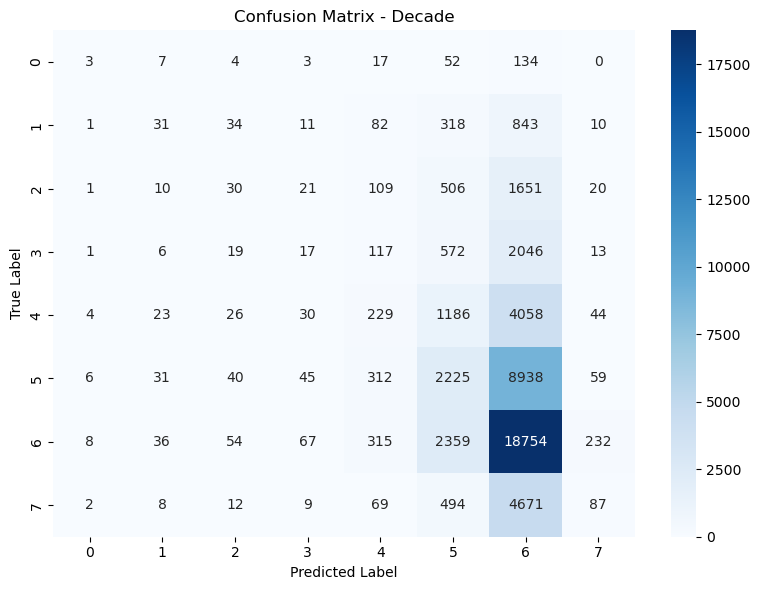


Top 20 features for decade:
                 feature  importance
0   unique_chord_density    0.079859
1   unique_5gram_density    0.076470
5       average_4overlap    0.072214
7       average_2overlap    0.071847
4       average_5overlap    0.069826
9            drone_ratio    0.069767
6       average_3overlap    0.069703
8        average_overlap    0.069108
3        maj_triad_ratio    0.062851
2        min_triad_ratio    0.059431
45        contains_G,D,C    0.008053
47        contains_D,C,G    0.007727
55        contains_G,C,D    0.007667
31        contains_C,D,C    0.007519
40        contains_G,F,G    0.007283
53        contains_C,G,C    0.007179
52        contains_C,G,D    0.007037
37     contains_G,C,Amin    0.006703
50        contains_C,D,G    0.006660
54        contains_G,C,G    0.006455


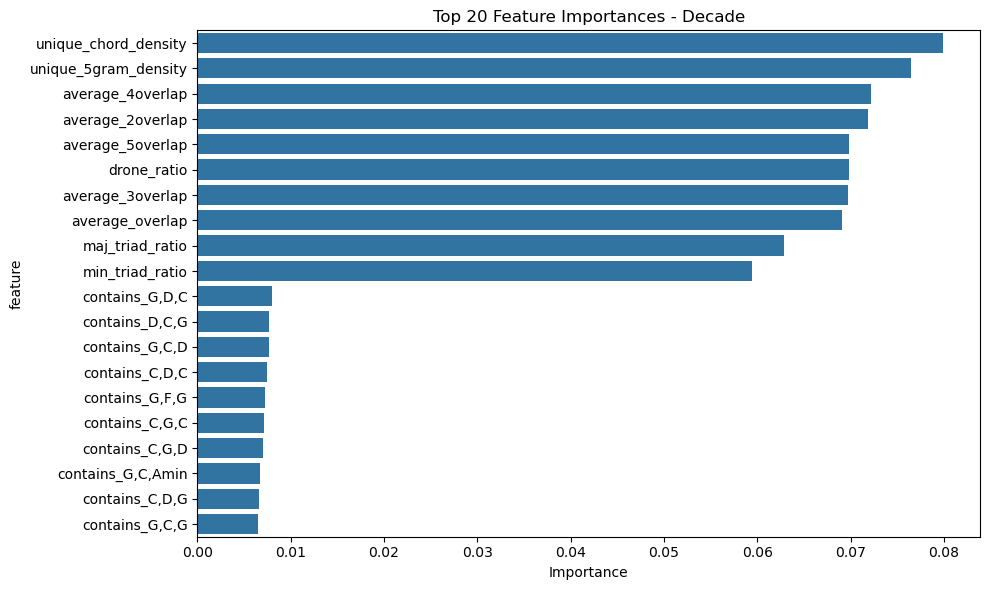

In [44]:
# Prepare data for random forest by decade

target_columns = data_columns[data_columns['column_type'] == 'target']['column_name'].tolist()


X = df[predictor_columns]
print(X.shape)
y = df['decade']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Random Forest
print(f"Training Random Forest for: decade")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decade')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': predictor_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 features for decade:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Decade')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Training set size: 204484
Test set size: 51122
Training Random Forest for: genre

Accuracy: 0.2794

Classification Report:
              precision    recall  f1-score   support

 alternative       0.21      0.13      0.16      7177
     country       0.34      0.36      0.35      7599
  electronic       0.00      0.00      0.00       342
        jazz       0.25      0.05      0.08       898
       metal       0.26      0.04      0.07      1720
         pop       0.29      0.59      0.39     12342
    pop rock       0.12      0.02      0.04      5765
        punk       0.25      0.07      0.11      2446
         rap       0.19      0.07      0.10      1471
      reggae       0.11      0.03      0.04       557
        rock       0.26      0.29      0.27      9763
        soul       0.16      0.03      0.05      1042

    accuracy                           0.28     51122
   macro avg       0.21      0.14      0.14     51122
weighted avg       0.25      0.28      0.24     51122



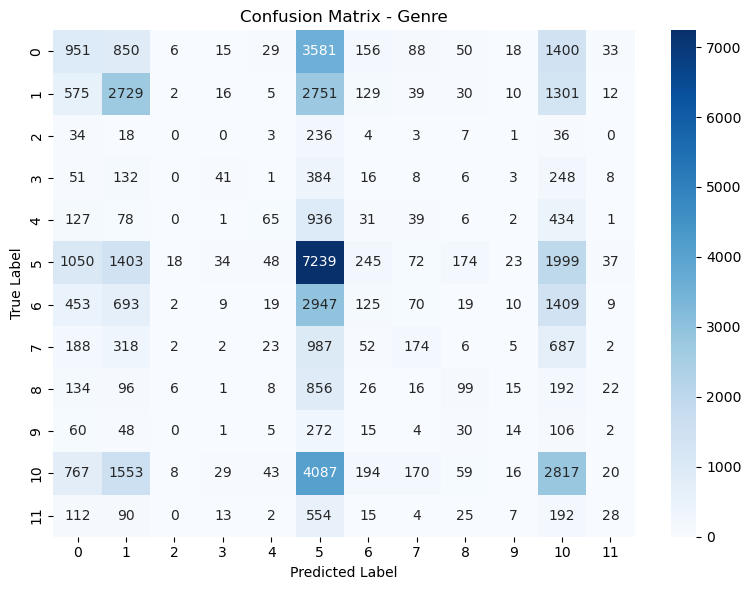


Top 20 features for genre:
                 feature  importance
1   unique_5gram_density    0.075460
0   unique_chord_density    0.074507
7       average_2overlap    0.070966
5       average_4overlap    0.070844
4       average_5overlap    0.070314
8        average_overlap    0.069603
6       average_3overlap    0.069329
9            drone_ratio    0.068965
3        maj_triad_ratio    0.064693
2        min_triad_ratio    0.059818
45        contains_G,D,C    0.008012
47        contains_D,C,G    0.007570
55        contains_G,C,D    0.007493
31        contains_C,D,C    0.007443
40        contains_G,F,G    0.007282
36     contains_Amin,G,C    0.007038
37     contains_G,C,Amin    0.006880
51     contains_C,G,Amin    0.006741
50        contains_C,D,G    0.006664
42     contains_C,Amin,G    0.006647


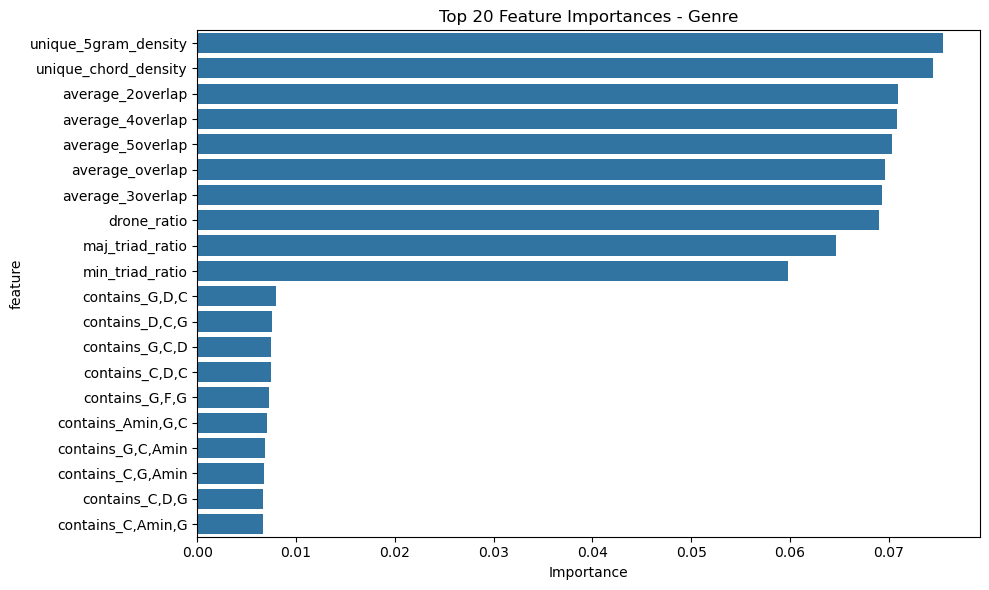

In [45]:
# Prepare data for random forest by genre
X = df[predictor_columns]
y = df['main_genre']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Random Forest
print(f"Training Random Forest for: genre")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Genre')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': predictor_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 features for genre:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Genre')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Training set size: 145686
Test set size: 36422
Training Random Forest for: spotify_popularity

RMSE: 16.9562
MAE: 13.8193
R² Score: 0.0061


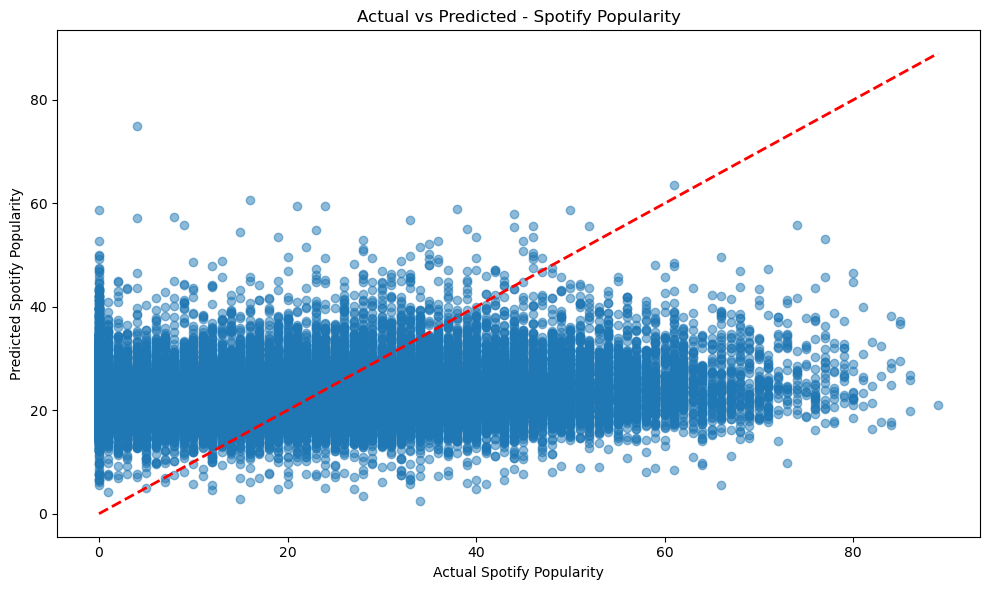


Top 20 features for spotify_popularity:
                 feature  importance
1   unique_5gram_density    0.103258
0   unique_chord_density    0.086267
5       average_4overlap    0.083896
7       average_2overlap    0.082327
4       average_5overlap    0.078993
6       average_3overlap    0.077936
3        maj_triad_ratio    0.076080
9            drone_ratio    0.075906
8        average_overlap    0.074740
2        min_triad_ratio    0.060349
53        contains_C,G,C    0.006850
45        contains_G,D,C    0.004847
54        contains_G,C,G    0.004620
55        contains_G,C,D    0.004530
36     contains_Amin,G,C    0.004463
37     contains_G,C,Amin    0.004435
52        contains_C,G,D    0.004406
56     contains_G,C,Emin    0.004340
75     contains_Emin,G,C    0.004254
47        contains_D,C,G    0.004253


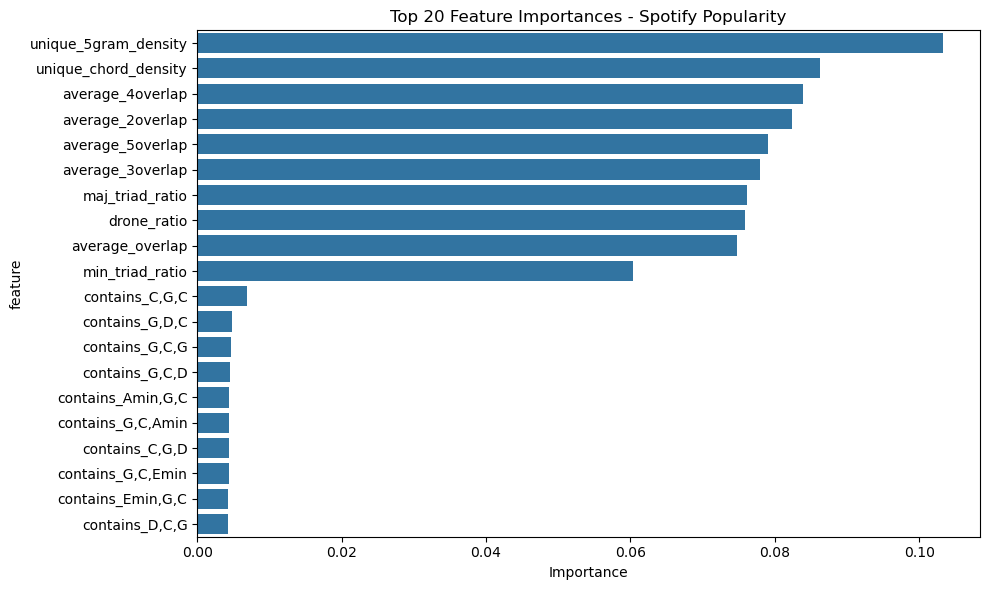

In [46]:
# Prepare data - drop NaNs for spotify_popularity
X = df[predictor_columns]
y = df['spotify_popularity']

# Drop rows with NaN in spotify_popularity
valid_indices = y.notna()
X_filtered = X[valid_indices]
y_filtered = y[valid_indices]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Random Forest
print(f"Training Random Forest for: spotify_popularity")

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nRMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Spotify Popularity')
plt.ylabel('Predicted Spotify Popularity')
plt.title('Actual vs Predicted - Spotify Popularity')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': predictor_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 features for spotify_popularity:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Spotify Popularity')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Lassos:

Training Lasso (L1) for: decade
Total data size: 255606
Using 5-fold cross-validation

Cross-validation accuracy scores: [0.43048003 0.43154477 0.4316817  0.43170126 0.43252284]
Mean CV accuracy: 0.4316 (+/- 0.0007)

Classification Report:
              precision    recall  f1-score   support

      1950.0       0.00      0.00      0.00      1098
      1960.0       0.13      0.00      0.00      6650
      1970.0       0.15      0.01      0.01     11741
      1980.0       0.13      0.00      0.00     13954
      1990.0       0.22      0.00      0.01     28002
      2000.0       0.29      0.13      0.18     58278
      2010.0       0.45      0.94      0.61    109125
      2020.0       0.00      0.00      0.00     26758

    accuracy                           0.43    255606
   macro avg       0.17      0.14      0.10    255606
weighted avg       0.30      0.43      0.30    255606



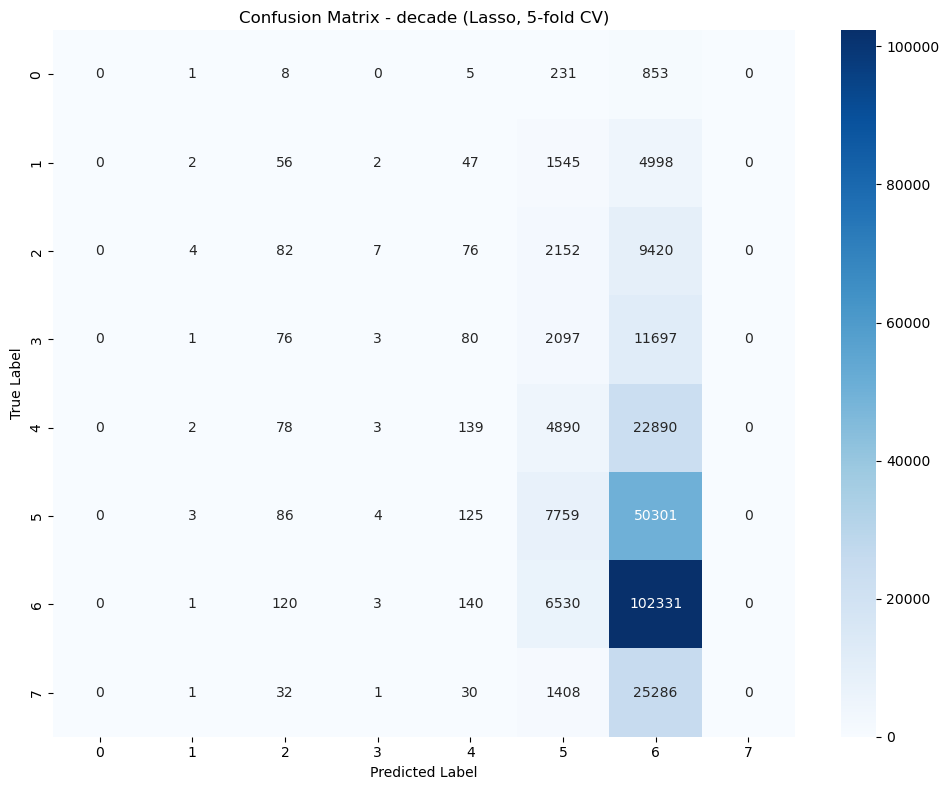


Number of features selected: 77 out of 77

Top 20 features for decade:
                 feature  importance
5       average_4overlap      1.5822
2        min_triad_ratio      1.3339
7       average_2overlap      1.3302
54        contains_G,C,G      0.8762
9            drone_ratio      0.8538
8        average_overlap      0.8515
48     contains_Emin,C,G      0.7627
46     contains_G,Amin,F      0.7624
0   unique_chord_density      0.7118
32     contains_F,Amin,G      0.7022
41     contains_F,G,Amin      0.6741
6       average_3overlap      0.6732
70   contains_F,C,G,Amin      0.6436
1   unique_5gram_density      0.5945
3        maj_triad_ratio      0.5706
44     contains_Amin,G,F      0.5684
4       average_5overlap      0.5590
50        contains_C,D,G      0.5477
56     contains_G,C,Emin      0.5273
72     contains_G,D,Amin      0.4919


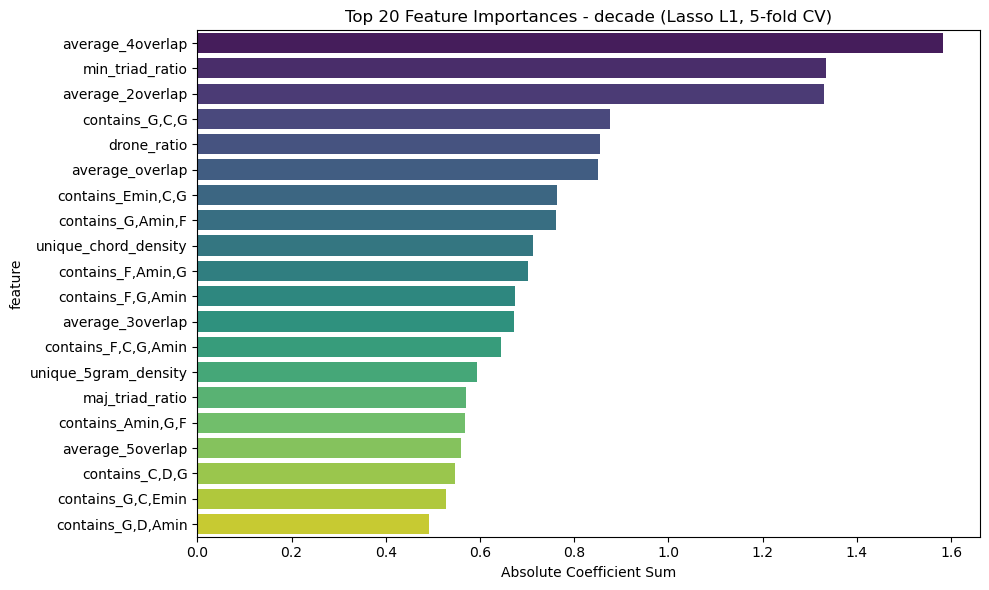

In [47]:
# Run Lasso for decade (multi-class classification)
from functions_L1_regularization import run_classification_lasso, run_regression_lasso
decade_importance = run_classification_lasso(df, predictor_columns, 'decade','~/Downloads', is_binary=False,savefile=False)

Training Lasso (L1) for: main_genre
Total data size: 255606
Using 5-fold cross-validation

Cross-validation accuracy scores: [0.29030554 0.28907885 0.28792473 0.29029166 0.28798341]
Mean CV accuracy: 0.2891 (+/- 0.0010)

Classification Report:
              precision    recall  f1-score   support

 alternative       0.26      0.06      0.09     35884
     country       0.33      0.35      0.34     37995
  electronic       0.00      0.00      0.00      1711
        jazz       0.00      0.00      0.00      4491
       metal       0.30      0.03      0.05      8597
         pop       0.29      0.68      0.41     61711
    pop rock       0.10      0.00      0.00     28824
        punk       0.20      0.00      0.01     12229
         rap       0.33      0.02      0.04      7354
      reggae       0.25      0.00      0.00      2783
        rock       0.27      0.33      0.29     48815
        soul       0.15      0.00      0.00      5212

    accuracy                           0.29    25560

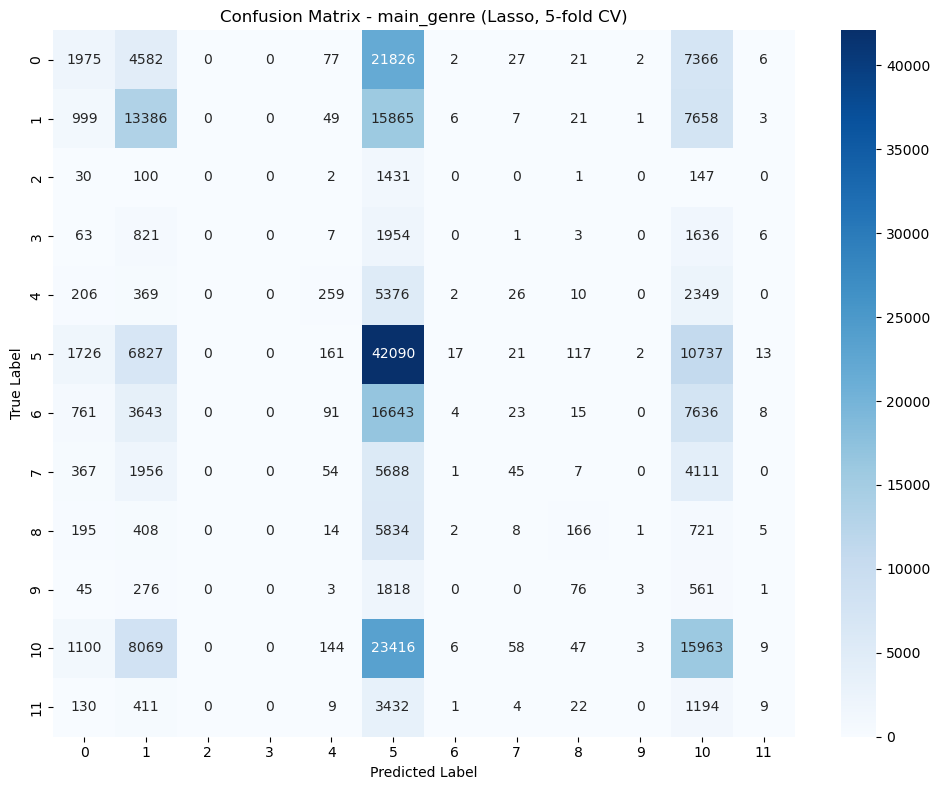


Number of features selected: 77 out of 77

Top 20 features for main_genre:
                 feature  importance
5       average_4overlap      3.3803
2        min_triad_ratio      2.4070
8        average_overlap      2.2690
6       average_3overlap      2.2535
1   unique_5gram_density      2.0676
3        maj_triad_ratio      1.4890
7       average_2overlap      1.3316
4       average_5overlap      1.2455
0   unique_chord_density      1.2110
9            drone_ratio      1.0135
73     contains_Amin,D,G      0.8856
50        contains_C,D,G      0.6868
54        contains_G,C,G      0.6785
46     contains_G,Amin,F      0.6676
41     contains_F,G,Amin      0.5696
52        contains_C,G,D      0.5417
48     contains_Emin,C,G      0.5195
75     contains_Emin,G,C      0.4807
51     contains_C,G,Amin      0.4628
55        contains_G,C,D      0.4601


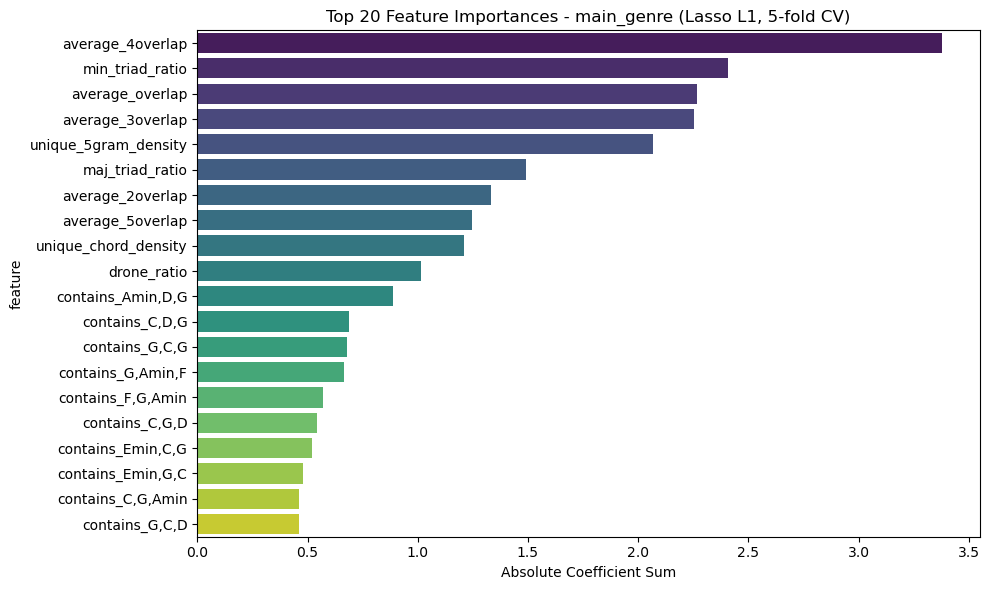

In [48]:
# Run Lasso for main_genre (multi-class classification)
genre_importance = run_classification_lasso(df, predictor_columns, 'main_genre', '.', is_binary=False,savefile=False)

Training Lasso (L1) for: spotify_popularity
Total data size: 182108
Using 5-fold cross-validation

Cross-validation R² scores: [0.03569191 0.03934033 0.03654209 0.03389449 0.03480554]
Mean CV R²: 0.0361 (+/- 0.0019)
Mean CV RMSE: 16.6596

Overall metrics on cross-validated predictions:
R² Score: 0.0361
RMSE: 16.6596
MAE: 13.6344


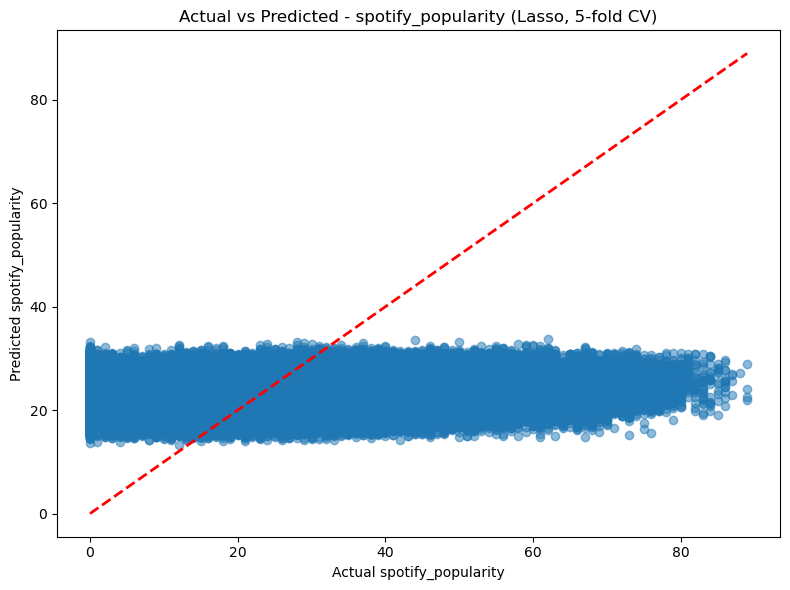


Number of features selected: 36 out of 77

Top 20 features for spotify_popularity:
                 feature  importance
5       average_4overlap      1.0978
3        maj_triad_ratio      1.0531
1   unique_5gram_density      0.9593
2        min_triad_ratio      0.5727
6       average_3overlap      0.3954
54        contains_G,C,G      0.3850
0   unique_chord_density      0.3760
53        contains_C,G,C      0.3336
9            drone_ratio      0.3176
7       average_2overlap      0.3169
50        contains_C,D,G      0.2926
17    contains_D,G,C,G,D      0.1726
46     contains_G,Amin,F      0.1676
62      contains_G,D,G,C      0.1668
44     contains_Amin,G,F      0.1635
70   contains_F,C,G,Amin      0.1503
4       average_5overlap      0.1242
39     contains_Amin,C,G      0.1217
49        contains_D,G,C      0.0924
41     contains_F,G,Amin      0.0835


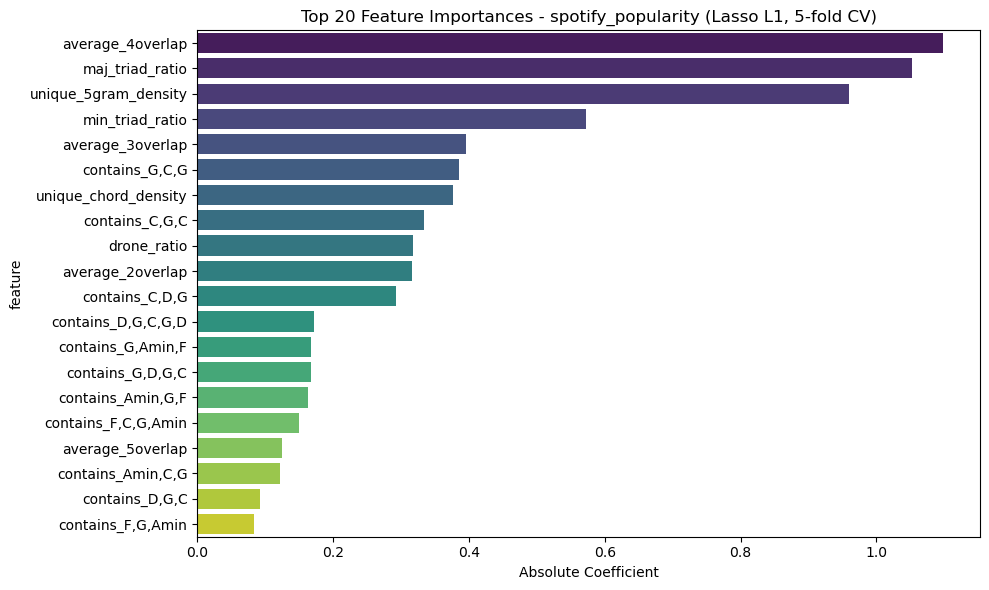

In [49]:
# Run Lasso for spotify_popularity (regression)
popularity_importance = run_regression_lasso(df, predictor_columns, 'spotify_popularity', '.',savefile=False)

With these baseline modelsRandom forest nor lasso are ever able to identify electronic music. See how genre prediction is effected it electronic music is dropped.

In [50]:
no_electronic_df=df[df.main_genre!='electronic']

Training set size: 203116
Test set size: 50779
Training Random Forest for: genre

Accuracy: 0.2855

Classification Report:
              precision    recall  f1-score   support

 alternative       0.20      0.12      0.15      7177
     country       0.35      0.37      0.36      7599
        jazz       0.26      0.05      0.08       898
       metal       0.21      0.03      0.05      1719
         pop       0.30      0.59      0.40     12342
    pop rock       0.15      0.03      0.04      5765
        punk       0.27      0.07      0.11      2446
         rap       0.22      0.08      0.12      1471
      reggae       0.15      0.04      0.06       557
        rock       0.27      0.30      0.28      9763
        soul       0.20      0.03      0.06      1042

    accuracy                           0.29     50779
   macro avg       0.23      0.15      0.16     50779
weighted avg       0.26      0.29      0.24     50779



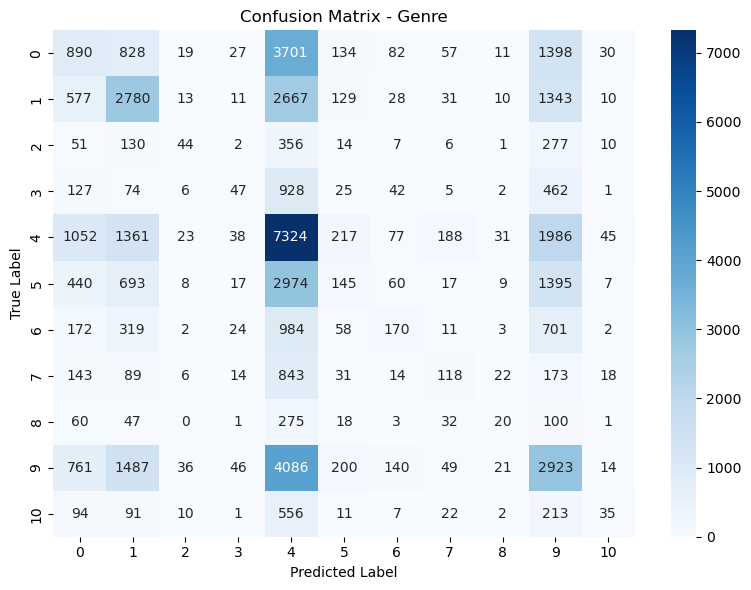


Top 20 features for genre:
                 feature  importance
1   unique_5gram_density    0.075216
0   unique_chord_density    0.074631
7       average_2overlap    0.071114
5       average_4overlap    0.070765
4       average_5overlap    0.070055
8        average_overlap    0.069491
6       average_3overlap    0.069343
9            drone_ratio    0.068937
3        maj_triad_ratio    0.064685
2        min_triad_ratio    0.059796
45        contains_G,D,C    0.008069
47        contains_D,C,G    0.007670
55        contains_G,C,D    0.007553
31        contains_C,D,C    0.007538
40        contains_G,F,G    0.007199
36     contains_Amin,G,C    0.007146
37     contains_G,C,Amin    0.006957
50        contains_C,D,G    0.006939
51     contains_C,G,Amin    0.006713
42     contains_C,Amin,G    0.006622


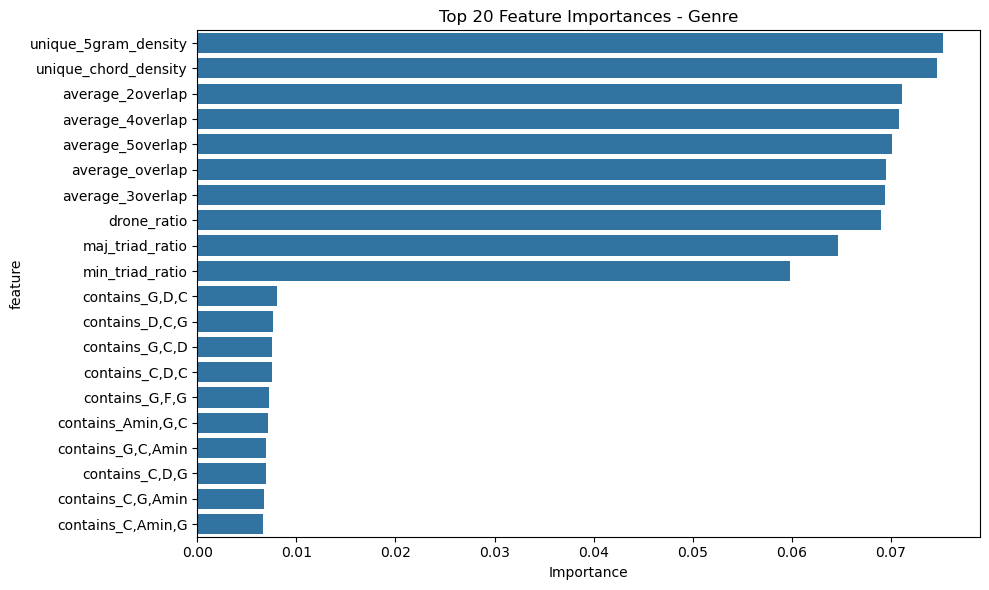

In [51]:
# Prepare data
X = no_electronic_df[predictor_columns]
y = no_electronic_df['main_genre']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Random Forest
print(f"Training Random Forest for: genre")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Genre')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': predictor_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 features for genre:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Genre')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Training Lasso (L1) for: main_genre
Total data size: 253895
Using 5-fold cross-validation

Cross-validation accuracy scores: [0.28980484 0.29080919 0.28852478 0.29262097 0.29321176]
Mean CV accuracy: 0.2910 (+/- 0.0017)

Classification Report:
              precision    recall  f1-score   support

 alternative       0.26      0.05      0.09     35884
     country       0.33      0.35      0.34     37995
        jazz       0.00      0.00      0.00      4491
       metal       0.30      0.03      0.05      8597
         pop       0.29      0.68      0.41     61711
    pop rock       0.16      0.00      0.00     28824
        punk       0.23      0.00      0.01     12229
         rap       0.33      0.02      0.04      7354
      reggae       0.23      0.00      0.00      2783
        rock       0.27      0.33      0.29     48815
        soul       0.13      0.00      0.00      5212

    accuracy                           0.29    253895
   macro avg       0.23      0.13      0.11    25389

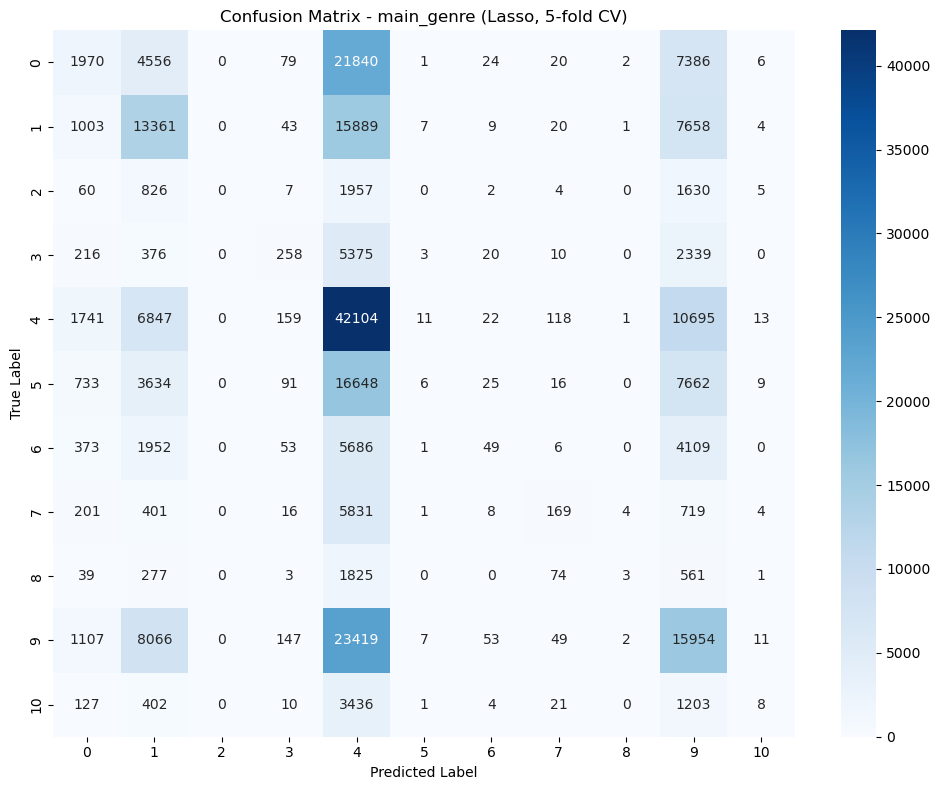


Number of features selected: 77 out of 77

Top 20 features for main_genre:
                 feature  importance
5       average_4overlap      2.8591
6       average_3overlap      2.0905
2        min_triad_ratio      2.0891
8        average_overlap      2.0548
1   unique_5gram_density      1.6539
3        maj_triad_ratio      1.4317
0   unique_chord_density      1.1174
4       average_5overlap      1.1040
7       average_2overlap      1.0608
9            drone_ratio      0.8990
73     contains_Amin,D,G      0.8129
54        contains_G,C,G      0.5802
50        contains_C,D,G      0.5523
46     contains_G,Amin,F      0.5515
52        contains_C,G,D      0.5445
48     contains_Emin,C,G      0.5185
51     contains_C,G,Amin      0.4626
55        contains_G,C,D      0.4233
41     contains_F,G,Amin      0.4125
56     contains_G,C,Emin      0.4079


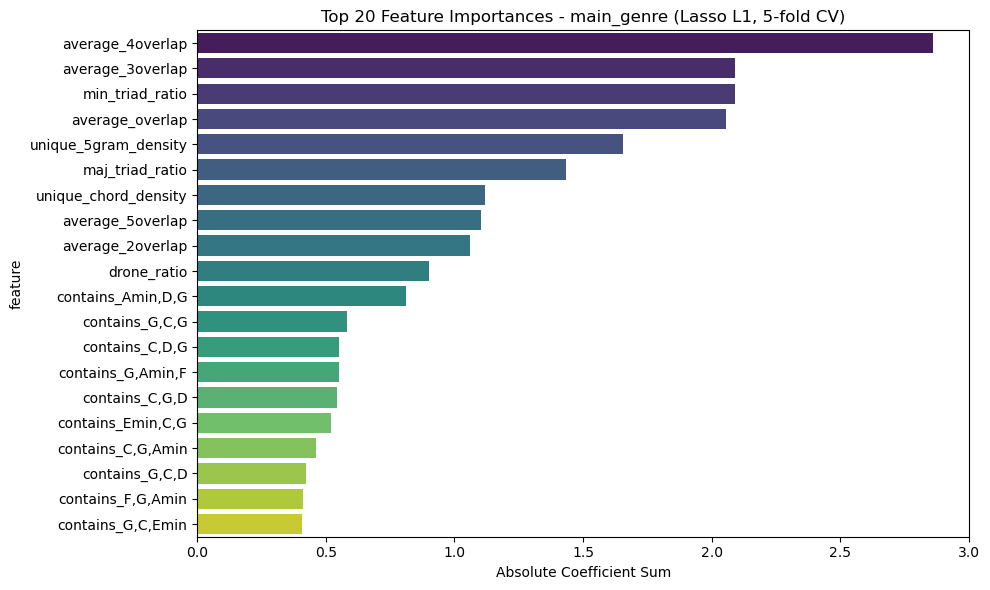

In [52]:
# Run Lasso for main_genre (multi-class classification)
genre_importance = run_classification_lasso(no_electronic_df, predictor_columns, 'main_genre', '.', is_binary=False,savefile=False)